CNN

<!-- http://192.168.210.234:8585/lab/tree/jl240925_23_WithAmount_aCodeCNN-Copy2.ipynb -->



In [2]:
import os, re, glob, pandas, numpy, time, datetime, tempfile, subprocess, timeout_decorator, openpyxl, math # , glob, pathlib, datetime, timeit
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import model_selection
from subprocess import Popen

from rdkit import rdBase, Chem, DataStructs
from rdkit.Chem import AllChem, Draw, PandasTools
from rdkit.Avalon import pyAvalonTools

In [3]:
from Function_241210 import Handle_OneHotEncoder, ShowROC, PlotHistory, OpenpyxlReadWorkbook, Handle_RocAucScore_AccuracyScore, Get_AutoSimilarities, LO_function_ForFingerprint


DNN definition

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler # TensorDataset, 
from torch.nn.utils.rnn import pack_sequence, pad_sequence

In [7]:
from torchviz import make_dot
from IPython.display import display

In [8]:
## Collate + DataLoader

class my_Dataset(Dataset):
    '''
    一般的なDatasetの使い方として定義。
    '''
    def __init__(self, xs, ys):
        self.explain_variable_data = xs
        self.target_variable_data = ys
   
    def __len__(self):
        return len(self.explain_variable_data)
    
    def __getitem__(self,idx):
        return self.explain_variable_data[idx], self.target_variable_data[idx]


def collate_fn_convert(batch):
    '''
    ミニバッチを取り出して長さを揃える関数 
    '''
    xs = pad_sequence(list(x for x,y in batch), batch_first=False, padding_value=0)
    ys = pad_sequence(list(y for x,y in batch), batch_first=False, padding_value=0)
    return xs, ys


def Handle_DataLoader(
    whole_explain_variable_data, whole_target_variable_data, index_lis, *, 
    batch_size=16, 
    collate_fn=None, 
):
    '''
    Convert train and validation sets to torch.Tensors and load them to DataLoader.
    '''
    return DataLoader(
        my_Dataset([whole_explain_variable_data[i] for i in index_lis], [whole_target_variable_data[i] for i in index_lis]), 
        # sampler=RandomSampler(train_data), # train_sampler, 
        batch_size=batch_size, 
        collate_fn=collate_fn, 
    )


# Prepare WholeData
def WholeData(
    xs, ys, *, 
    LO=lambda m:Chem.RDKFingerprint(m), 
) : 
    ts_init = time.time()
    whole_explain_variable_data = list()
    whole_target_variable_data = list()
    for j,(ofp,y) in enumerate(zip(xs,ys)) : 
        try : 
            df = OpenpyxlReadWorkbook(ofp, IndexPos=0, ColumnPos=0).get('concat')

        except : 
            print('pass at :',ofp)
        else : 
            bm = df.loc[:,'USE']
            source = df[bm].loc[:,['smiles','amount']].values
            ll = [[*LO_function_ForFingerprint(smi, LO=LO),v] for smi,v in source]
            # bm = [b for b,fp,v in ll] # b=false; Failed in Getting-Fingerprint
            npa = numpy.hstack([
                numpy.array([fp for b,fp,v in ll if b ]), 
                numpy.array([[v] for b,fp,v in ll if b ]), 
            ])
            whole_explain_variable_data.append(torch.tensor(npa).to(torch.float) ) 
            whole_target_variable_data.append(torch.tensor(y).to(torch.float) ) 
    print(time.time()-ts_init, '(s) / Prepare WholeData')
    return(whole_explain_variable_data, whole_target_variable_data)
    

In [9]:
# CNN
class CNN(nn.Module):
    def __init__(self, *,
                 filter_sizes=[3, 4, 5], 
                 num_filters=[100, 100, 100], 
                 dropout=0.5, 
                 embed_dim=None,
                 y_dim=None, 
                 sm_dim=None, 
                ):
        """
        Args:
            embed_dim (int): ベクトルの次元。
            filter_sizes (List[int]): フィルター サイズのリスト。 デフォルト: [3、4、5]
            num_filters (List[int]): フィルターの数のリスト。`filter_sizes` と同じ長さです。 デフォルト: [100, 100, 100]
            dropout (float): ドロップアウト率。 デフォルト: 0.5
            y_dim : Target variable の次元数（デフォルト; 目的変数,反転させた目的変数）
            sm_dim : Target variable の Softmax / Log_Softmaxにおける制御方向。デフォルト:softmax_dim=1 
        """

        super(CNN, self).__init__()

        self.embed_dim = embed_dim
        self.y_dim = y_dim
        self.sm_dim = sm_dim
        
        self.conv1d_list = nn.ModuleList([ nn.Conv1d(in_channels=self.embed_dim, out_channels=nf, kernel_size=fs) for nf,fs in zip(num_filters,filter_sizes) ])
        
        # Fully-connected layer and Dropout
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(in_features=numpy.sum(num_filters), out_features=math.prod(self.y_dim))
        
    
    def forward(self, x_embed): 
        """
        Perform a forward pass through the network.
        """

        # x_embed = self.embedding(input_ids).float()                                               # Get embeddings
        x_reshaped = x_embed # .permute(1,2,0)                                                      # Permute `x_embed`, original ; .permute(0,2,1)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]                   # Apply CNN and ReLU. 
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[2]) for x_conv in x_conv_list] # Max pooling.
        x_cat = torch.cat([x_pool.squeeze(dim=2) for x_pool in x_pool_list], dim=1)                 # Concatenate x_pool_list to feed the fc layer

        # Drop-out
        x = x_cat
        x = self.dropout(x)
        x0 = torch.reshape(self.fc(x),(-1,*self.y_dim))                                               # Compute logits => stack (re-flatten)
        
        # Regression / classification process
        x1 = torch.nn.functional.softmax(x0, dim=self.sm_dim)                                        # 反転付きのOne-Hot => dim=softmax_dim
        x2 = torch.nn.functional.log_softmax(x0 ,dim=self.sm_dim)                                    # Multilabel Classification
        
        return x0,x1,x2
        

dataload


In [10]:
cwd = os.getcwd()
NotUseFiles = [
    os.path.join(cwd, 'datalink', 'CRESOL.240929', 'CRESOL178.xlsx'), # CRESOL178
    os.path.join(cwd, 'datalink', 'CRESOL.240929', 'CRESOL9.xlsx'), # CRESOL9
]


219 / 221


,Aerial part,Bulb,Dried material,Flowers,Fruit,Herb,Leaf,Leaf and flower,Rhizome,Root,Seed,Shoot,Stem,Whole plant,Wood
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
215,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
216,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
217,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


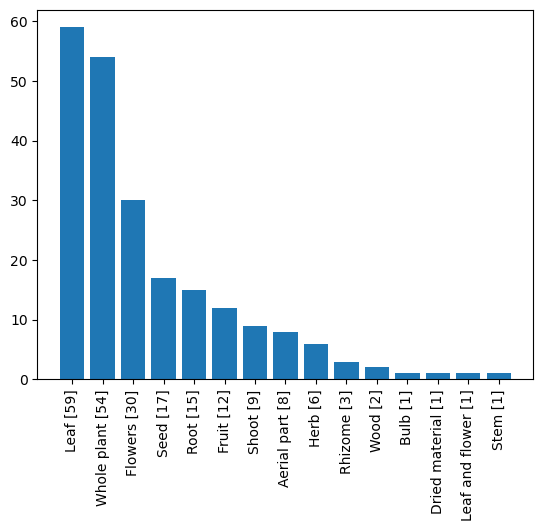

219 219 221 (9,)


In [11]:
# データロード

# CRESOL Files(xlsx)
wdir, ext = os.path.join(cwd, 'datalink', "CRESOL.240929"), '.xlsx'
d_CRESOL = dict((os.path.basename(p).strip(ext),p) for p in glob.glob(os.path.join(wdir,'*')) if p.endswith(ext))


# Main File(CSIR CIMAP AROMA  Essential Oil.xlsx)
ofp = os.path.join(cwd, 'datalink', "CSIR CIMAP AROMA  Essential Oil.xlsx")
df = OpenpyxlReadWorkbook(ofp, IndexPos=0, ColumnPos=0).get('table0')
ps_ofp = df.loc[:,"('Details [href]', 1)"].map(lambda crid:d_CRESOL.get(crid))
bm = ps_ofp.map(lambda ofp : not(ofp in NotUseFiles) )
print(sum(bm), '/', len(bm))


# Target variables ; One-Hot
cl = Handle_OneHotEncoder()
out = cl.fittransform(df[bm].loc[:,'Plant Tissue Name'].values.reshape(-1, 1)).out() # 通常のOne-Hot
display(out.df_1H)


# countplot
ps = out.df_1H.sum().sort_values(ascending=False)
plt.figure()
plt.bar(list(x[0]+' ['+str(v)+']' for x,v in ps.items()), list(x for x in ps.values))
plt.xticks(rotation=90)
plt.show()


TargetNames = [
    'Aerial part',
    # 'Bulb',
    # 'Dried material',
    'Flowers',
    'Fruit',
    'Herb',
    'Leaf',
    # 'Leaf and flower',
    # 'Rhizome',
    'Root',
    'Seed',
    'Shoot',
    # 'Stem',
    'Whole plant',
    # 'Wood',
]

# データ準備
xs = list(x for x in ps_ofp[bm].values) # [0:100] # df.loc[:,'FilePath.SplitBySerialNo']
# ys = list(numpy.stack([ar,numpy.logical_not(ar)], axis=1).T for ar in out.df_1H.loc[:,TargetNames].astype(bool).values) # [0:100] # AddInverse # Collate Stack OK 最終的にはこの目的変数を使用する
ys = list(ar for ar in out.df_1H.loc[:,TargetNames].astype(bool).values) # [0:100] # nn.BCEWithLogitsLoss()用 # ar.reshape(*ar.shape,1)
print(len(xs),len(ys),len(df),ys[0].shape)


In [12]:
# # 検証事項

# FingerPrintFun = lambda m:AllChem.GetMorganFingerprintAsBitVect(m, 2,2048)
# FingerPrintFun = lambda m:AllChem.GetMACCSKeysFingerprint(m)
# FingerPrintFun = lambda m:pyAvalonTools.GetAvalonFP(m)
FingerPrintFun = lambda m:Chem.RDKFingerprint(m)

In [13]:
%time 
whole_explain_variable_data, whole_target_variable_data = WholeData(xs, ys, LO=FingerPrintFun)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs
10.904377937316895 (s) / Prepare WholeData


In [14]:
# # Prepare CV set (as dict)
n_splits=5
shuffle=True
random_state=7


# Prepare CV index wholedata版
kf = model_selection.KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state) # https://smart-hint.com/ml/kfold/
CV_dict = dict(enumerate(kf.split(xs,ys)))


0
Epoch: 1 	 Train 	Loss: 0.405 	 Val   	Loss: 0.305
Epoch: 2 	 Train 	Loss: 0.240 	 Val   	Loss: 0.243
Epoch: 3 	 Train 	Loss: 0.146 	 Val   	Loss: 0.282
Epoch: 6 	 Train 	Loss: 0.053 	 Val   	Loss: 0.265
Epoch: 10 	 Train 	Loss: 0.016 	 Val   	Loss: 0.314
Epoch: 20 	 Train 	Loss: 0.004 	 Val   	Loss: 0.384
Epoch: 30 	 Train 	Loss: 0.002 	 Val   	Loss: 0.441
Epoch: 60 	 Train 	Loss: 0.000 	 Val   	Loss: 0.515
Loss vs epochs


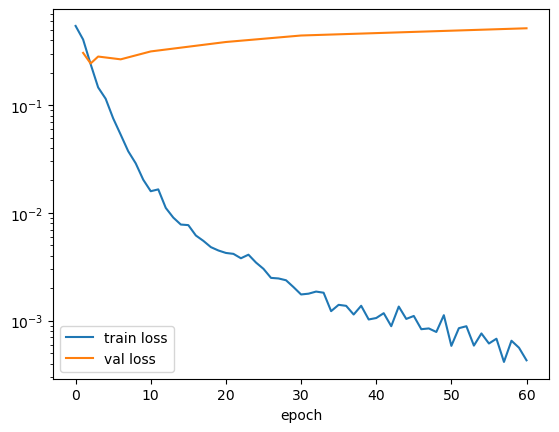

1
Epoch: 1 	 Train 	Loss: 0.459 	 Val   	Loss: 0.446
Epoch: 2 	 Train 	Loss: 0.242 	 Val   	Loss: 0.331
Epoch: 3 	 Train 	Loss: 0.163 	 Val   	Loss: 0.337
Epoch: 6 	 Train 	Loss: 0.055 	 Val   	Loss: 0.368
Epoch: 10 	 Train 	Loss: 0.022 	 Val   	Loss: 0.436
Epoch: 20 	 Train 	Loss: 0.012 	 Val   	Loss: 0.464
Epoch: 30 	 Train 	Loss: 0.007 	 Val   	Loss: 0.540
Epoch: 60 	 Train 	Loss: 0.002 	 Val   	Loss: 0.573
Loss vs epochs


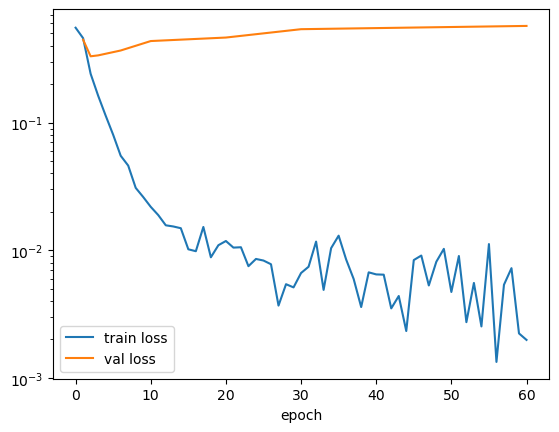

2
Epoch: 1 	 Train 	Loss: 0.460 	 Val   	Loss: 0.399
Epoch: 2 	 Train 	Loss: 0.228 	 Val   	Loss: 0.320
Epoch: 3 	 Train 	Loss: 0.159 	 Val   	Loss: 0.302
Epoch: 6 	 Train 	Loss: 0.045 	 Val   	Loss: 0.307
Epoch: 10 	 Train 	Loss: 0.024 	 Val   	Loss: 0.324
Epoch: 20 	 Train 	Loss: 0.009 	 Val   	Loss: 0.371
Epoch: 30 	 Train 	Loss: 0.007 	 Val   	Loss: 0.396
Epoch: 60 	 Train 	Loss: 0.002 	 Val   	Loss: 0.441
Loss vs epochs


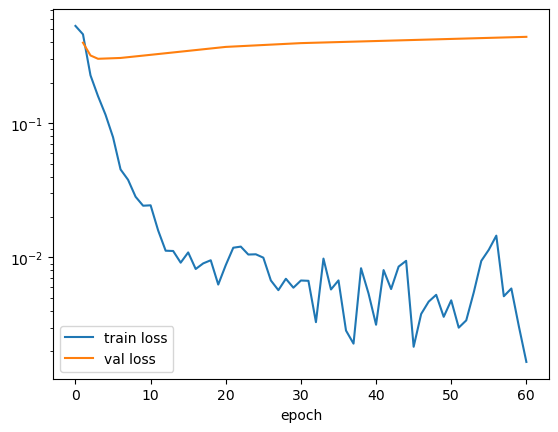

3
Epoch: 1 	 Train 	Loss: 0.427 	 Val   	Loss: 0.450
Epoch: 2 	 Train 	Loss: 0.265 	 Val   	Loss: 0.310
Epoch: 3 	 Train 	Loss: 0.179 	 Val   	Loss: 0.313
Epoch: 6 	 Train 	Loss: 0.062 	 Val   	Loss: 0.273
Epoch: 10 	 Train 	Loss: 0.025 	 Val   	Loss: 0.303
Epoch: 20 	 Train 	Loss: 0.008 	 Val   	Loss: 0.367
Epoch: 30 	 Train 	Loss: 0.010 	 Val   	Loss: 0.361
Epoch: 60 	 Train 	Loss: 0.005 	 Val   	Loss: 0.427
Loss vs epochs


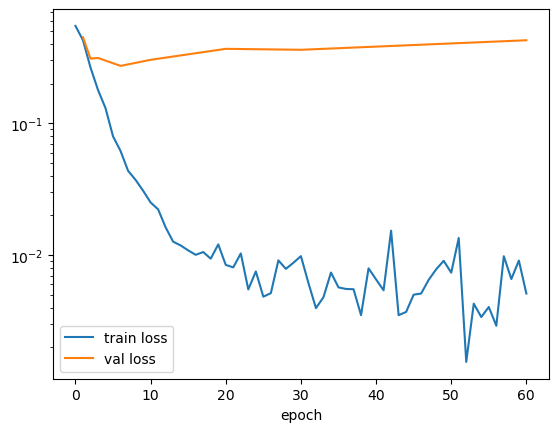

4
Epoch: 1 	 Train 	Loss: 0.431 	 Val   	Loss: 0.357
Epoch: 2 	 Train 	Loss: 0.240 	 Val   	Loss: 0.317
Epoch: 3 	 Train 	Loss: 0.169 	 Val   	Loss: 0.288
Epoch: 6 	 Train 	Loss: 0.069 	 Val   	Loss: 0.254
Epoch: 10 	 Train 	Loss: 0.023 	 Val   	Loss: 0.287
Epoch: 20 	 Train 	Loss: 0.008 	 Val   	Loss: 0.327
Epoch: 30 	 Train 	Loss: 0.003 	 Val   	Loss: 0.352
Epoch: 60 	 Train 	Loss: 0.002 	 Val   	Loss: 0.423
Loss vs epochs


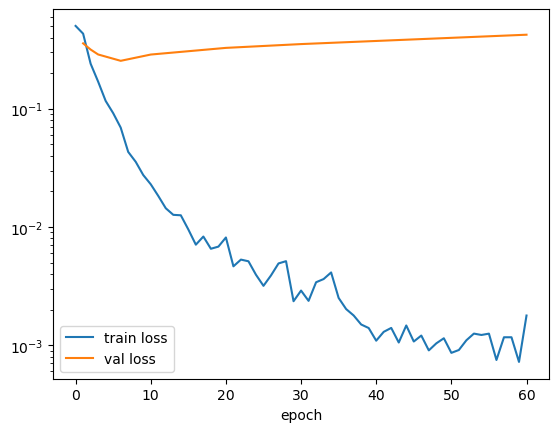

CPU times: user 1h 51min 25s, sys: 4min 6s, total: 1h 55min 31s
Wall time: 7min 9s


In [15]:
%%time
# 回帰

sm_dim = 1
batch_size=32
max_epoch=61
thr = 0.5 # For Use P-Proba (BCEWithLogitsLoss)


# 学習の実行（べた書き）

ValidationResult = list()
for cvno,t in CV_dict.items() : 
    print(cvno)
    train_loss = []
    val_loss = []
    
    train_loader, val_loader = ( Handle_DataLoader(
        whole_explain_variable_data, 
        whole_target_variable_data, 
        ixs, 
        batch_size=batch_size, 
        collate_fn=collate_fn_convert, 
    ) for ixs in t ) 
    
    model = CNN(
        filter_sizes=[5, 9, 17], 
        num_filters=[300, 300, 300], 
        embed_dim=whole_explain_variable_data[0].shape[-1], 
        y_dim=list(set(y.shape for y in ys))[0], 
        sm_dim=sm_dim, # SoftMax dimension 基本的には変更しない
    )
    model = model.to(device)
    
    # 最適化手法
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0.02)
    # optimizer = torch.optim.Adadelta(model.parameters(), lr=0.25, rho=0.95) 
    
    criterion = nn.BCEWithLogitsLoss() # 軽量
    # criterion=torch.nn.functional.nll_loss 
    # criterion=torch.nn.BCELoss()
    # criterion=nn.CrossEntropyLoss() # use for original CNN-NLP
    

    for epoch in range(max_epoch) :
        loss_local = 0 # ; accu_local = [] # reset
    
        # train 
        model.train()
        for i,data in enumerate(train_loader):
            explain_variable_data = data[0].permute(1,2,0).to(device)
            # target_variable_data = data[1].permute(1,0,2).to(device)
            target_variable_data = data[1].permute(1,0).to(device) # BCEwithLogitLoss
            alabel = torch.argmax(target_variable_data, dim=sm_dim)
            
            optimizer.zero_grad()
            out,out_sig,out_lsm = model(explain_variable_data) # 伝搬
            loss = criterion(out, target_variable_data) #loss計算 # nn.BCEWithLogitsLoss 用
            # loss = criterion(out_lsm, alabel) #loss計算 # Log_SoftMax + OneHotTarget 専用
            # loss = criterion(out_sig, target_variable_data) #loss計算 # https://qiita.com/Mony0_S/items/2d87918e0fdc77ccecb5
            loss.backward() # バックプロパゲーション
            optimizer.step()
            loss_local += target_variable_data.size(0) * loss.item()
        else : 
            train_loss.append((epoch, loss_local / len(train_loader.dataset))) 
    
        # val
        if epoch in [1,2,3,6,10,20,30,60,100,200,300,600,1000,2000,3000,6000,max_epoch-1] : 
            loss_local = 0 # loss reset
            alabel_local = [] # alabel
            plabel_local = [] # plabel
            pproba_local = [] # pproba
            
            model.eval() #推論モード
            with torch.no_grad(): # 勾配計算をしないようにするコンテキストマネージャ
                for i,data in enumerate(val_loader):
                    explain_variable_data = data[0].permute(1,2,0).to(device)
                    # target_variable_data = data[1].permute(1,0,2).to(device)
                    # alabel = torch.argmax(target_variable_data, dim=sm_dim)
                    target_variable_data = data[1].permute(1,0).to(device) # BCEwithLogitLoss
                    alabel = target_variable_data > thr # BCEwithLogitLoss
                    
                    out,out_sig,out_lsm = model(explain_variable_data) # 伝搬
                    loss = criterion(out, target_variable_data) #loss計算 # nn.BCEWithLogitsLoss 用
                    # loss = criterion(out_lsm, alabel) #loss計算 # Log_SoftMax + OneHotTarget 専用
                    # loss = criterion(out_sig, target_variable_data) #loss計算 
                    loss_local += target_variable_data.size(0) * loss.item()
                    
                    alabel_local.append(alabel) # alabel # torch.argmax(batch.y, dim=sm_dim) 
                    # # LSM ver
                    # plabel_local.append(torch.argmax(out_lsm.data, dim=sm_dim)) # plabel 
                    # pproba_local.append(torch.exp(out_lsm)[:,1,:].numpy()) # pproba 
                    # BCEWithLogitsLoss ver
                    plabel_local.append(torch.sigmoid(out).numpy() > thr ) # plabel 
                    pproba_local.append(torch.sigmoid(out).numpy() ) # pproba 
                
                else : 
                    val_loss.append((epoch, loss_local / len(val_loader.dataset))) 
                    ValidationResult.append([
                        cvno, 
                        epoch, 
                        numpy.vstack(alabel_local), # all_labels 
                        numpy.vstack(pproba_local), # all_pproba 
                        numpy.vstack(plabel_local), # y_pred 
                    ])
            print(
                'Epoch: {}'.format(epoch), '\t', 
                'Train \tLoss: {:.3f}'.format(train_loss[-1][1]), '\t', 
                'Val   \tLoss: {:.3f}'.format(val_loss[-1][1]), 
            )
    else : 
        PlotHistory(
            train_loss = list(l for e,l in train_loss), 
            val_loss = list(l for e,l in val_loss), 
            train_epochs = list(e for e,l in train_loss), 
            val_epochs = list(e for e,l in val_loss), 
        )


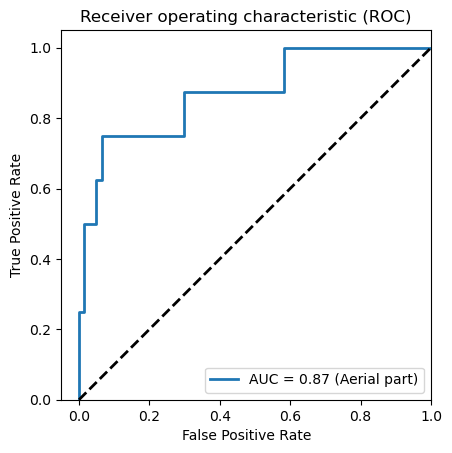

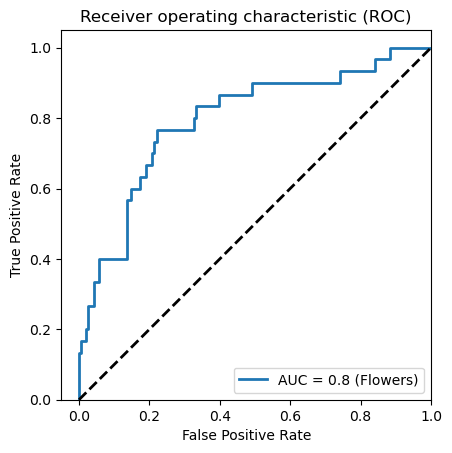

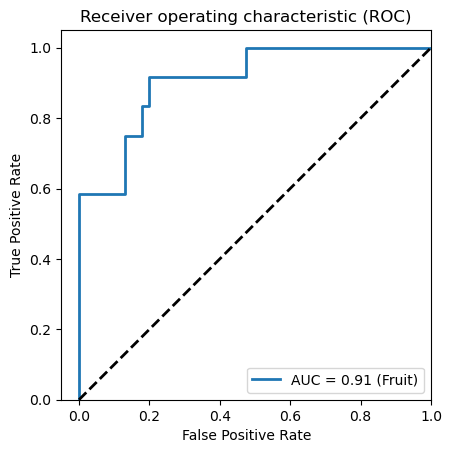

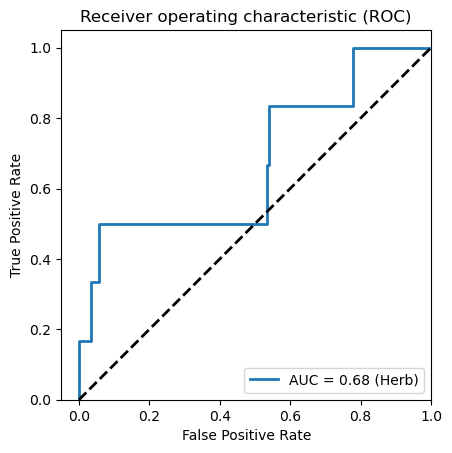

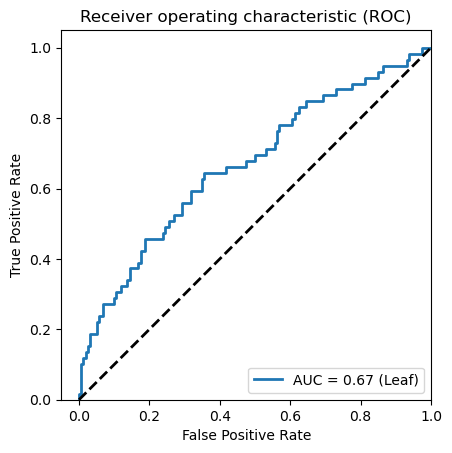

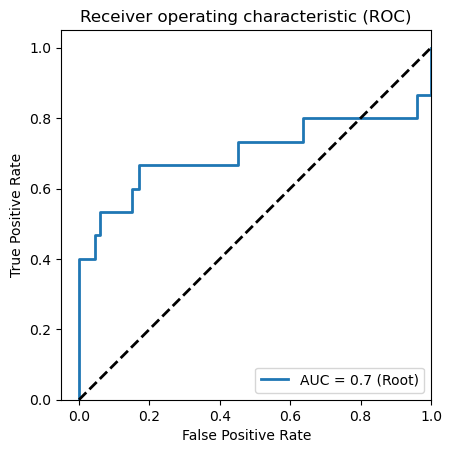

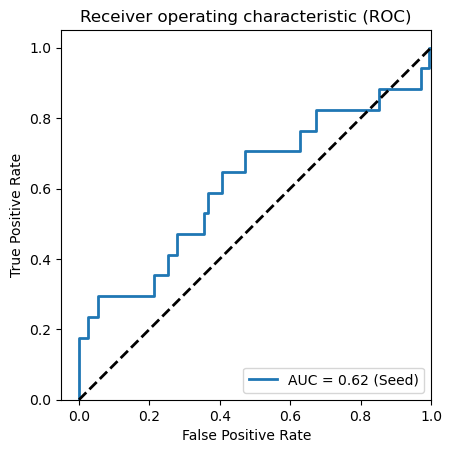

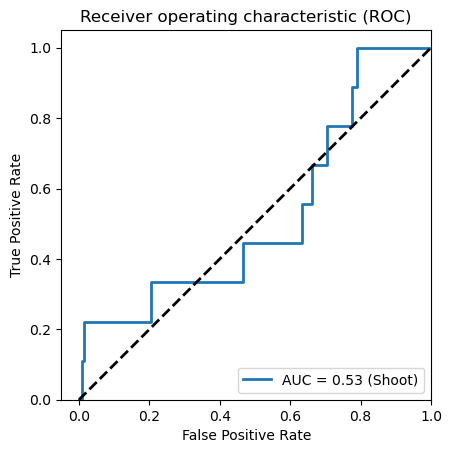

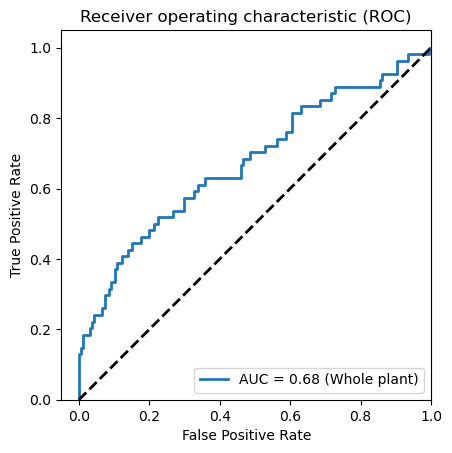

In [16]:
# CVSet越しのnumpy.vstackあり

res = list()
for epoch,dfp in pandas.DataFrame(ValidationResult).groupby(1) : 
    if epoch ==30 : 
        ShowROC_InLine=True
    else : 
        ShowROC_InLine=False
        
    stacked_all_labels = numpy.vstack(dfp.loc[:,2].values)
    stacked_all_pproba = numpy.vstack(dfp.loc[:,3].values)
    for tl,pp,lb in zip(stacked_all_labels.T, stacked_all_pproba.T, TargetNames) : 
        res.append(((epoch,lb),Handle_RocAucScore_AccuracyScore(tl, pp, ShowROC_InLine=ShowROC_InLine, comment=lb)))
else : 
    df_ValidationResult = pandas.DataFrame(dict(res)).T
    df_AUC_History = df_ValidationResult.loc[:,'auc'].unstack().T


In [17]:
df_AUC_History

,1,2,3,6,10,20,30,60
Aerial part,0.651659,0.847156,0.828199,0.872038,0.864929,0.879739,0.872038,0.864336
Flowers,0.689947,0.723457,0.695238,0.761552,0.780423,0.789065,0.795414,0.792945
Fruit,0.581723,0.774960,0.709340,0.888889,0.883655,0.907810,0.907407,0.920290
Herb,0.412363,0.417840,0.715962,0.562598,0.690923,0.708920,0.676056,0.605634
Leaf,0.524682,0.600318,0.611335,0.648729,0.654661,0.667903,0.667691,0.697564
Root,0.631373,0.786275,0.700654,0.703922,0.692484,0.700654,0.701634,0.687582
Seed,0.500874,0.690740,0.546884,0.607746,0.622306,0.616191,0.615317,0.652301
Shoot,0.367196,0.421164,0.629101,0.531217,0.449735,0.521164,0.526455,0.579894
Whole plant,0.556678,0.655556,0.610774,0.687654,0.683951,0.683277,0.675421,0.683726


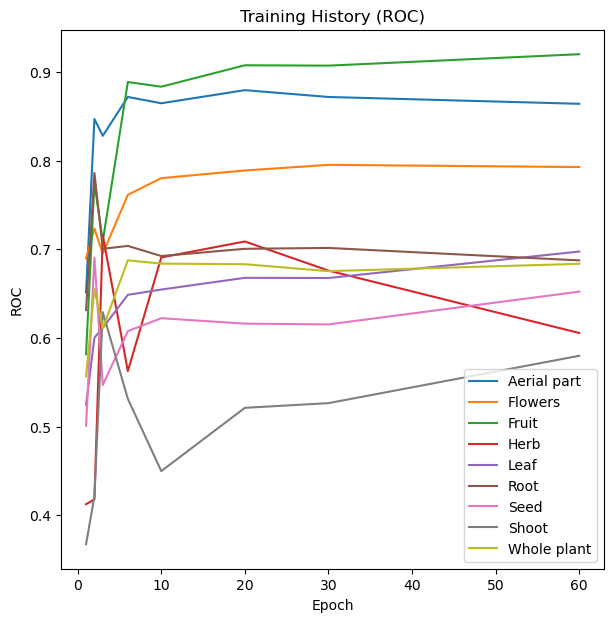

In [18]:
# df_AUC_History可視化

fig = plt.figure(figsize=(7,7)) #...1
for i in df_AUC_History.index : 
    ps = df_AUC_History.loc[i,:]
    plt.plot(
        [c for c,v in ps.items()], 
        [v for c,v in ps.items()], 
        # color=sns_palette_d.get(i), 
        label=i, 
    )
else : 
    # # plt.xlim([-0.05, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('Epoch')
    plt.ylabel('ROC')
    plt.title('Training History (ROC)')
    plt.legend(loc="lower right")
    # plt.gca().set_aspect('equal', adjustable='box') # https://qiita.com/show2214/items/064c671709dda08d78c8
plt.show()


In [19]:
summary(model)

Layer (type:depth-idx)                   Param #
CNN                                      --
├─ModuleList: 1-1                        --
│    └─Conv1d: 2-1                       3,073,800
│    └─Conv1d: 2-2                       5,532,600
│    └─Conv1d: 2-3                       10,450,200
├─Dropout: 1-2                           --
├─Linear: 1-3                            8,109
Total params: 19,064,709
Trainable params: 19,064,709
Non-trainable params: 0

In [20]:
ここでていし

NameError: name 'ここでていし' is not defined